<table style="width: 100%; border: none;">
    <tr>
        <!-- Columna para la imagen -->
        <td style="width: 100px; vertical-align: top; padding-right: 20px;">
            <img src="figs/uah1.png" style="width: 80px; height: auto; border-radius: 50%; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);">
        </td>
        <!-- Columna para los textos -->
        <td style="vertical-align: top;">
            <h1 style="font-size: 32px; color: #003366; margin: 0;">Geospatial Data Science</h1>
            <h2 style="font-size: 24px; color: #005599; margin-top: 10px; margin-bottom: 10px;">Tema 6: Relaciones espaciales y <i>joins</i> en Geopandas</h2>
            <h3 style="font-size: 18px; color: #666; margin-bottom: 10px; font-weight: normal;">
                Advanced Programming · Máster en Tecnologías de la Información Geográfica
            </h3>
            <h4 style="font-size: 16px; color: #444;">Profesora: <span style="font-weight: bold; color: #222;">Julia Clemente</span></h4>
        </td>
    </tr>
</table>

In [31]:
# Avoid interference with GDAL from other external software due to environment variables used: GDAL_DATA and PROJ_LIB

import os
import getpass

usuario = getpass.getuser()

# os.environ['GDAL_DATA'] = f'/opt/anaconda3/envs/geoenv/share/gdal'
# os.environ['PROJ_LIB'] = f'/opt/anaconda3/envs/geoenv/share'

# en windows
os.environ['GDAL_DATA'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\gdal'
os.environ['PROJ_LIB'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\proj'

In [32]:
%matplotlib inline

import pandas as pd
import geopandas
import matplotlib.pyplot as plt

In [33]:
countries = geopandas.read_file("data/ne_110m_admin_0_countries.zip")
cities = geopandas.read_file("data/ne_110m_populated_places.zip")
rivers = geopandas.read_file("data/ne_50m_rivers_lake_centerlines.zip")

## Relaciones espaciales

Un aspecto relevante de los datos geoespaciales es que se puede analizar la relación entre varios objetos espaciales (si se superponen, se cruzan, uno está contenido en otro, etc.).

Las relaciones topológicas y de teoría de conjuntos en SIG suelen basarse en el modelo DE-9IM. Consulte para más información: https://en.wikipedia.org/wiki/Spatial_relation 

![](figs/SpatialRelations.png)
Fuente: [Krauss, CC BY-SA 3.0](https://en.wikipedia.org/wiki/Spatial_relation#/media/File:TopologicSpatialRelarions2.png)

### Relaciones entre objetos individuales

Primero creemos algunos objetos espaciales pequeños "de juguete".  

Un polígono:

In [34]:
belgium = countries.loc[countries['name'] == 'Belgium', 'geometry'].item()

Usamos `.item()` aquí para extraer el objeto de geometría escalar de `GeoSeries` de longitud 1.

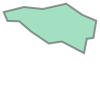

In [35]:
belgium

Dos puntos:

In [36]:
paris = cities.loc[cities['name'] == 'Paris', 'geometry'].item()
brussels = cities.loc[cities['name'] == 'Brussels', 'geometry'].item()

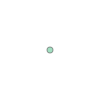

In [11]:
paris

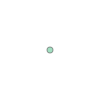

In [12]:
brussels

Y un `LineString`:

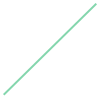

In [13]:
from shapely.geometry import LineString

line = LineString([paris, brussels])
line

Vamos a visualizar los 4 objetos de geometría juntos; podemos crear una `GeoSeries` para mostrarlos fácilmente junto con el método `.plot()` de geopandas:

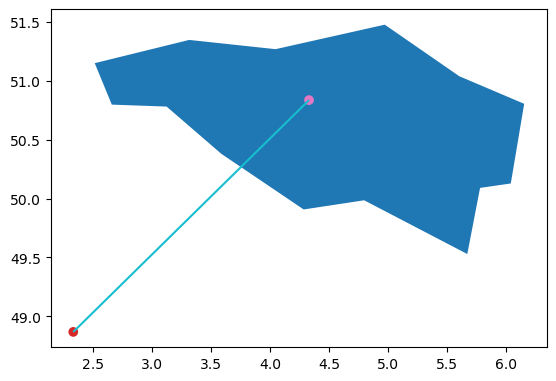

In [14]:
geopandas.GeoSeries([belgium, paris, brussels, line]).plot(cmap='tab10')
plt.show()

Puedes reconocer la forma abstracta de Bélgica. Bruselas (capital de Bélgica) se encuentra dentro de Bélgica y esta relación espacial se puede demostrar utilizando los objetos geométricos individuales de la siguiente manera:

In [37]:
brussels.within(belgium)

True

Y al revés, Bélgica contiene a Bruselas:

In [16]:
belgium.contains(brussels)

True

Y también chequear que París no se encuentra en Bélgica:

In [17]:
belgium.contains(paris)

False

In [18]:
paris.within(belgium)

False

La línea recta trazada de París a Bruselas no está completamente dentro de Bélgica, pero sí se cruza con ella:

In [19]:
belgium.contains(line)

False

In [20]:
line.intersects(belgium)

True

### Relaciones espaciales con GeoDataFrames

Los mismos métodos vistos anteriormente, y que están disponibles en geometrías `shapely` individuales, también están disponibles como métodos en objetos `GeoSeries` / `GeoDataFrame`.

Por ejemplo, si llamamos al método `contains`  en el conjunto de datos mundial con el punto `paris`, realizará esta verificación espacial para cada país en el dataframe `countries`:

In [21]:
countries.contains(paris)

0      False
1      False
2      False
3      False
4      False
       ...  
172    False
173    False
174    False
175    False
176    False
Length: 177, dtype: bool

Debido a que lo anterior nos da un resultado booleano, podemos usarlo para filtrar el dataframe:

In [22]:
countries[countries.contains(paris)]

,iso_a3,name,continent,pop_est,gdp_md_est,geometry
55,FRA,France,Europe,67106161.0,2699000.0,"MULTIPOLYGON (((2.51357 51.14851, 2.65842 50.7..."


Y se obtiene, claro, que Francia es el único país del mundo en el que se encuentra París.

Otro ejemplo, extrayendo el cordón umbilical del río Amazonas en América del Sur, podemos consultar por qué países fluye el río:

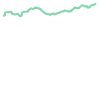

In [23]:
amazon = rivers[rivers['name'] == 'Amazonas'].geometry.item()
amazon

In [24]:
countries[countries.crosses(amazon)]  # or .intersects

,iso_a3,name,continent,pop_est,gdp_md_est,geometry
22,BRA,Brazil,South America,207353391.0,3081000.0,"POLYGON ((-57.62513 -30.21629, -56.2909 -28.85..."
35,COL,Colombia,South America,47698524.0,688000.0,"POLYGON ((-66.87633 1.25336, -67.06505 1.13011..."
124,PER,Peru,South America,31036656.0,410400.0,"POLYGON ((-69.52968 -10.95173, -68.66508 -12.5..."


<div class="alert alert-success" style="font-size:100%">

**RECOPILACIÓN DE PREDICADOS ESPACIALES:**

Descripción general de las diferentes funciones para comprobar las relaciones espaciales (*funciones de predicados espaciales*):

* `equals`
* `contains`
* `crosses`
* `disjoint`
* `intersects`
* `overlaps`
* `touches`
* `within`
* `covers`
* `covered_by`


Consulte aquí para ver la descripción de los métodos anteriores: https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships

Consulte aquí para una descripción detallada de la semántica de las operaciones asociadas: https://en.wikipedia.org/wiki/DE-9IM
</div>

## Ejercicios:

Partimos de nuevo de los conjuntos de datos de París para hacer ejercicio. Comencemos a importarlos nuevamente y a convertirlos directamente al CRS proyectado local:

In [25]:
districts_Paris = geopandas.read_file("data/paris_districts.geojson").to_crs(epsg=2154)
stations_Paris = geopandas.read_file("data/paris_bike_stations.geojson").to_crs(epsg=2154)

<div class="alert alert-info">

**EJERCICIO 1: La Torre Eiffel**

La Torre Eiffel es una torre de celosía de hierro construida en el siglo XIX y es probablemente la vista más emblemática de París.

La ubicación de la Torre Eiffel es: x -> 648237,3 e y -> 6862271,9

* Crear un objeto de tipo punto de Shapely con las coordenadas de la Torre Eiffel y asígnelo a una variable llamada `eiffel`. Imprimir el resultado.
* Comprobar si la Torre Eiffel está ubicada dentro del distrito de _Montparnasse_ (proporcionado).
* Comprobar si el distrito de _Montparnasse_ contiene la ubicación de la estación de bicicletas _14033 - DAGUERRE GASSENDI_.
* Calcular la distancia entre la Torre Eiffel y la estación de bicicletas (nota: en este caso, la distancia se devuelve en metros).


<details><summary>Consejos:</summary>

* La clase `Point` está disponible en el submódulo `shapely.geometry`
* Se puede crear un punto pasando las coordenadas x e y al constructor `Point()`.
* El método `within()` comprueba si el objeto está ubicado dentro de la geometría pasada (usada como `geometry1.within(geometry2)`).
* El método `contains()` comprueba si el objeto contiene la geometría pasada (usada como `geometry1.contains(geometry2)`).
* Para calcular la distancia entre dos geometrías se puede utilizar el método `distance()` de una de las geometrías.

</details>

</div>

In [ ]:
# Import the Point geometry
from shapely.geometry import Point

In [ ]:
# %load solutions/03-exercise1.py

In [ ]:
# %load solutions/03-exercise2.py
# Print the result

In [ ]:
districts_Paris.head()

In [ ]:
stations_Paris.head()

In [ ]:
# Accessing the Montparnasse geometry (Polygon)
district_montparnasse = districts_Paris.loc[52, 'geometry']

In [ ]:
# Accessing the geometry of bike_station 14033 - DAGUERRE GASSENDI (Polygon)
bike_station = stations_Paris.loc[293, 'geometry']

In [ ]:
# %load solutions/03-exercise3.py

In [ ]:
# %load solutions/03-exercise4.py

In [ ]:
# %load solutions/03-exercise5.py

<div class="alert alert-info">

**EJERCICIO 2: ¿En qué distrito se encuentra la Torre Eiffel?**

Ya tenemos una geometría de tipo "Punto" para su ubicación y hemos comprobado que no está ubicado en el distrito de Montparnasse. Ahora determinaremos en cuál de los distritos de París *está* ubicado.

* Crear una máscara booleana (o filtro) que indique si cada distrito contiene la Torre Eiffel o no. Llame al resultado `mask_Eiffel`.
* Filtrar el dataframe `distrits_Paris` con la máscara booleana anterior e imprimir el resultado.


<details><summary>Consejos:</summary>

* Para verificar si cada polígono en el conjunto de datos de distritos contiene un solo punto, podemos usar el método `contains()` del GeoDataFrame `districts_Paris`.
* Se puede filtrar las filas de un DataFrame según una condición pasando la máscara booleana a `df[..]`.

</details>

</div>

In [ ]:
# Construct a point object for the Eiffel Tower
eiffel = Point(648237.3, 6862271.9)

In [ ]:
# %load solutions/03-exercise6.py

In [ ]:
# %load solutions/03-exercise7.py

<div class="alert alert-info">

**EJERCICIO 3: ¿A qué distancia está la estación de bicicletas más cercana?**

Ahora nos interesan las estaciones de bicicletas cercanas a la Torre Eiffel. Para explorarlos, visualicemos la propia Torre Eiffel y las estaciones de bicicletas a 1 km.

Para realizar la tarea, podemos calcular la distancia a la Torre Eiffel de cada una de las estaciones. Basándonos en este resultado, podemos crear una máscara que tome "True" si la estación está dentro de 1 km y "False" en caso contrario. Luego, usar la máscara para filtrar el GeoDataFrame de las estaciones. Finalmente, hacemos una visualización de este subconjunto. Este es el procedimiento que debe pensar antes de programar, y luego ir paso a paso:

* Calcular la distancia a la Torre Eiffel para cada estación y llama al resultado "dist_eiffel" (o como quiera).
* Imprimir la distancia a la estación más cercana (que es el mínimo de `dist_eiffel`).
* Seleccionar las filas del GeoDataFrame `stations_Paris` en las que  la distancia a la Torre Eiffel es inferior a 1 km (tenga en cuenta que la distancia está en metros). Llame al resultado `stations_eiffel` (o como quiera).

<details><summary>Consejos:</summary>

* El método `.distance()` de un GeoDataFrame funciona por elementos: calcula la distancia entre cada geometría en el GeoDataFrame y la geometría pasada al método.
* Una Serie tiene un método `.min()` para calcular el valor mínimo.
* Para crear una máscara booleana basada en una condición, podemos hacer por ejemplo: `s < 100`.

</details>

</div>

In [ ]:
# %load solutions/03-exercise8.py

In [ ]:
# %load solutions/03-exercise9.py

In [ ]:
# %load solutions/03-exercise10.py

In [ ]:
# Make a plot of the close-by bike stations using matplotlib and contextily
import matplotlib.pyplot as plt
import contextily

fig, ax = plt.subplots(figsize=(8, 8))

stations_eiffel.to_crs(epsg=3857).plot(ax=ax)

geopandas.GeoSeries([eiffel], crs='EPSG:2154').to_crs(epsg=3857).plot(ax=ax, color='red')
contextily.add_basemap(ax)
ax.set_axis_off()
plt.show()

In [ ]:
# Make a plot of the close-by bike stations using matplotlib and contextily
m = stations_eiffel.explore(marker_kwds=dict(radius=5))

geopandas.GeoSeries([eiffel], crs='EPSG:2154').explore(m=m, color='red', marker_kwds=dict(radius=5))

---

## Uniones espaciales

Hemos utilizado métodos de relaciones espaciales para comprobar en qué país se encontraba una determinada ciudad. Pero ¿y si queremos realizar esta misma operación para cada ciudad y país? Por ejemplo, podríamos querer saber para cada ciudad en qué país se encuentra.

En jerga tabular, esto implicaría agregar una columna al dataframe de nuestras ciudades con el nombre del país en el que se encuentra. Dado que el nombre del país está contenido en el conjunto de datos de los países, necesitamos combinar (o "join") información de ambos conjuntos de datos. Unirse en una ubicación (en lugar de una columna compartida) se denomina "unión espacial".

¿Cómo lo solucionaremos?: basándonos en los datasets de `countries` y `city`, determinaremos, para cada ciudad, el país en el que se encuentra.

Para resolver este problema, utilizaremos el concepto de operación de "spatial join": combinar información de conjuntos de datos geoespaciales en función de su relación espacial.

### Resumen: unir dataframes

Pandas proporciona funcionalidad para unir o fusionar dataframes de diferentes maneras. Puede consultar una descripción general en: https://www.geeksforgeeks.org/python-pandas-merging-joining-and-concatenating/ y documentación completa aquí: https://pandas.pydata.org/pandas-docs/stable/merging.html

Para ilustrar el concepto de unir la información de dos datasets  con pandas, tomemos un pequeño subconjunto de nuestros conjuntos de datos de ciudades y países:

In [ ]:
cities2 = cities[cities['name'].isin(['Bern', 'Brussels', 'London', 'Paris'])].copy()
cities2['iso_a3'] = ['CHE', 'BEL', 'GBR', 'FRA']

In [ ]:
cities2

In [ ]:
countries2 = countries[['iso_a3', 'name', 'continent']]
countries2.head()

Agregamos una columna 'iso_a3' al dataset `cities`, indicando un código del país de la ciudad. Este código de país también está presente en el conjunto de datos `countries`, lo que nos permite fusionar esos dos *data frames* de datos en función de la columna común.

Unir el dataset de `cities` con `countries` transferirá información adicional sobre los países (el nombre completo, el continente) al dataset `cities`, basándose en una clave común:

In [ ]:
cities2.merge(countries2, on='iso_a3')

**Pero** para este ejemplo ilustrativo agregamos la columna común manualmente, que no está presente en el conjunto de datos original. Sin embargo, todavía podemos saber cómo unir esos dos datasets en función de sus coordenadas espaciales.

### Resumen: relaciones espaciales entre objetos

En el apartado anterior hemos visto la noción de relaciones espaciales entre objetos geométricos: *within*, *contains*, *intersects*, etc.

En este caso, sabemos que cada una de las ciudades está ubicada *dentro* de uno de los países, o al revés, que cada país puede *contener* múltiples ciudades.

Podemos probar dichas relaciones utilizando los métodos que hemos visto en el tema anterior:

In [ ]:
france = countries.loc[countries['name'] == 'France', 'geometry'].squeeze()
france

In [ ]:
cities.within(france)

Lo anterior nos da una serie booleana, que indica para cada punto en nuestro dataframes de `cities` si está ubicado dentro del área de Francia o no.
Debido a que el resultado es una serie booleana, podemos usarla para filtrar el dataset original y así mostrar solo aquellas ciudades que realmente están dentro de Francia:

In [ ]:
cities[cities.within(france)]

<small>Nota: el resultado anterior es incorrecto, pero esto se debe simplemente a la tosquedad del conjunto de datos de los países.</small>

Ahora podríamos repetir el análisis anterior para cada uno de los países y agregar una columna al dataframe de `cities` que indique este país. Sin embargo, eso sería tedioso de hacer manualmente y también es exactamente lo que nos proporciona la operación de unión espacial.



## Operación de unión espacial

<div class="alert alert-success" estilo="font-size:100%">

**SPATIAL JOIN** = *transferir atributos de una capa a otra según su relación espacial* <br>


Diferentes partes de esta operación:

* El GeoDataFrame al que queremos agregar información
* El GeoDataFrame que contiene la información que queremos agregar
* La relación espacial que queremos usar para hacer coincidir ambos conjuntos de datos ('intersects', 'contains', 'within')
* El tipo de unión: unión izquierda o interna (_left_ o _inner_ join)

![](figs/illustration-spatial-join.svg)

</div>

En este caso, queremos unir el dataframe `cities` con la información del dataframe `countries`, en base a la relación espacial entre ambos conjuntos de datos.

Usamos la función [`geopandas.sjoin`](https://geopandas.org/en/v0.5.0/reference/geopandas.sjoin.html):

In [26]:
joined = geopandas.sjoin(cities, countries, predicate='within', how='left')

In [27]:
joined

,name_left,geometry,index_right,iso_a3,name_right,continent,pop_est,gdp_md_est
0,Vatican City,POINT (12.45339 41.90328),79.0,ITA,Italy,Europe,6.213780e+07,2221000.0
1,San Marino,POINT (12.44177 43.9361),79.0,ITA,Italy,Europe,6.213780e+07,2221000.0
2,Vaduz,POINT (9.51667 47.13372),9.0,AUT,Austria,Europe,8.754413e+06,416600.0
3,Lobamba,POINT (31.2 -26.46667),152.0,SWZ,Swaziland,Africa,1.467152e+06,11060.0
4,Luxembourg,POINT (6.13 49.61166),97.0,LUX,Luxembourg,Europe,5.941300e+05,58740.0
...,...,...,...,...,...,...,...,...
238,Rio de Janeiro,POINT (-43.22697 -22.92308),22.0,BRA,Brazil,South America,2.073534e+08,3081000.0
239,São Paulo,POINT (-46.62697 -23.55673),22.0,BRA,Brazil,South America,2.073534e+08,3081000.0
240,Sydney,POINT (151.18323 -33.91807),8.0,AUS,Australia,Oceania,2.323241e+07,1189000.0
241,Singapore,POINT (103.85387 1.29498),111.0,MYS,Malaysia,Asia,3.138199e+07,863000.0


In [28]:
joined[joined["name_right"] == "France"]

,name_left,geometry,index_right,iso_a3,name_right,continent,pop_est,gdp_md_est
10,Monaco,POINT (7.40691 43.73965),55.0,FRA,France,Europe,67106161.0,2699000.0
13,Andorra,POINT (1.51649 42.5),55.0,FRA,France,Europe,67106161.0,2699000.0
186,Geneva,POINT (6.14003 46.21001),55.0,FRA,France,Europe,67106161.0,2699000.0
235,Paris,POINT (2.33139 48.86864),55.0,FRA,France,Europe,67106161.0,2699000.0


In [29]:
joined['continent'].value_counts()

continent
Asia             59
Africa           57
Europe           46
North America    26
South America    14
Oceania           8
Name: count, dtype: int64

## Ejercicios

Usaremos nuevamente los conjuntos de datos de París para hacer algunos ejercicios. Empecemos a importarlos:

In [30]:
districts_Paris = geopandas.read_file("data/paris_districts.geojson").to_crs(epsg=2154)
stations_Paris = geopandas.read_file("data/paris_bike_stations.geojson").to_crs(epsg=2154)

<div class="alert alert-info">

**EJERCICIO 4:**

* Determinar para cada estación de bicicletas en qué distrito se encuentra (¡utilizando una unión espacial!). Llame al resultado `joined`.

<details><summary>Consejos</summary>

- La función `geopandas.sjoin()` toma como primer argumento el dataframe al que queremos añadir información, y como segundo argumento el dataframe que contiene esta información adicional.

</details>

</div>

In [ ]:
# %load solutions/03-exercise11.py

In [ ]:
# %load solutions/03-exercise12.py

<div class="alert alert-info">

**EJERCICIO 5: Mapa de densidad de árboles por distrito (I)**

Utilizando un conjunto de datos de todos los árboles en los espacios públicos de París, el objetivo es crear un mapa de la densidad de árboles por distrito. Primero debemos averiguar cuántos árboles contiene cada distrito, y usaremos este resultado para calcular la densidad y crear un mapa.

Para obtener el recuento de árboles por distrito, primero necesitamos saber en qué distrito se encuentra cada árbol, lo cual podemos hacer con una unión espacial. Luego, utilizando el resultado de la unión espacial, calcularemos la cantidad de árboles ubicados en cada distrito usando la funcionalidad 'group-by' de pandas.

- Importar el conjunto de datos de árboles `"paris_trees.gpkg"` y llame al resultado `trees_Paris`.
- Leer también el conjunto de datos de distritos que hemos visto anteriormente (`"paris_districts.geojson"`) y llámelo `distrits_Paris`. Convertir este dataset al mismo CRS que el conjunto de datos de árboles.
- Agregar una columna con el `'district_name'` al conjunto de datos de árboles usando una unión espacial. Llame al resultado `joined`.

<detalles><summary>Consejos:</summary>

- Recuerde, podemos realizar una unión espacial con la función `geopandas.sjoin()`.
- `geopandas.sjoin()` toma como primer argumento el dataframe al que queremos agregar información, y como segundo argumento el dataframe que contiene esta información adicional.
- El argumento `predicate` se usa para especificar qué relación espacial entre ambos datasets queremos usar para unir (las opciones son `'intersects'`, `'contains'`, `'within'`).

</details>

</div>

In [ ]:
# %load solutions/03-exercise13.py

In [ ]:
# %load solutions/03-exercise14.py

In [ ]:
districts_Paris

In [ ]:
# %load solutions/03-exercise15.py

<div class="alert alert-info">

**EJERCICIO 6: Mapa de densidad de árboles por distrito (II)**

Calcule el número de árboles ubicados en cada distrito: agrupe el DataFrame `joined` por la columna `district_name` y calcule el tamaño de cada grupo. Llame a la serie resultante `trees_by_district`. <br>

Luego, convierta `trees_by_district` en un DataFrame para el siguiente ejercicio.

<details><summary>Consejos:</summary>

- La sintaxis general de `group-by` en pandas es: `df.groupby('key').aggregation_method()`, sustituyendo 'key' y 'aggregation_method' con el nombre de columna y el método apropiados.
- Para saber el tamaño de los grupos, podemos utilizar el método `.size()`.

</details>

</div>

In [ ]:
# %load solutions/03-exercise16.py

In [ ]:
# Convert the series to a DataFrame and specify column name
trees_by_district = trees_by_district.to_frame(name='n_trees')

In [ ]:
# Inspect the result
trees_by_district.head()

<div class="alert alert-info">

**EJERCICIO 7: Mapa de densidad de árboles por distrito (III)**

Ahora que hemos obtenido el número de árboles por distrito, podemos hacer el mapa de los distritos coloreados por la densidad de árboles.

Para esto, primero necesitamos fusionar la cantidad de árboles en cada distrito que calculamos en el paso anterior (`trees_by_district`) con el conjunto de datos de los distritos. Usaremos la función [`pd.merge()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html) para unir dos dataframes basados en una columna común.

Dado que no todos los distritos tienen el mismo tamaño, para la visualización debemos comparar la densidad de árboles: el número de árboles en relación con el área.

- Utilizar la función `pd.merge()` para fusionar los dataframes `districts` y `trees_by_district` en la columna `'district_name'`. Llame al resultado `distritos_tree`.
- Agregar una columna `'n_trees_per_area'` al dataframe `'districts_trees`, basada en la columna `'n_trees'` dividida por el área.
- Hacer un gráfico del dataframe `districts_trees`, usando la columna `'n_trees_per_area'` para determinar el color de los polígonos.


<details><summary>Consejos</summary>

- La función pandas `pd.merge()` toma los dos dataframes que desea fusionar como los dos primeros argumentos.
- El nombre de la columna en la que desea fusionar ambos conjuntos de datos se puede especificar con la palabra clave `on`.
- Se puede acceder a una columna de un DataFrame con `df['col']`, mientras que se puede agregar una columna a un DataFrame con `df['new_col'] = valores` donde `valores` puede ser el resultado de un cálculo.
- Recuerde, el área de cada geometría en un GeoSeries o GeoDataFrame se puede recuperar usando el atributo `area`. Por tanto, considerando un GeoDataFrame `gdf`, entonces `gdf.geometry.area` devolverá una Serie con el área de cada geometría.
- Podemos utilizar el método `.plot()` de un GeoDataFrame para realizar una visualización de las geometrías.
- Para usar una de las columnas del GeoDataFrame para determinar el color de relleno, use la palabra clave `column=`.


</details>

</div>

In [ ]:
# %load solutions/03-exercise17.py

In [ ]:
# %load solutions/03-exercise18.py

In [ ]:
# %load solutions/03-exercise19.py

<small><small><i>
Los notebooks de este tutorial están basados parcialmente en el material de Joris Van den Bossche @ **[GitHub](https://jorisvandenbossche.github.io/)**
</i></small></small>

> *© 2025, Julia Clemente Párraga (<mailto:juliaclementep@gmail.com>). Licensed under [MIT License](https://opensource.org/license/mit/)*